<a href="https://colab.research.google.com/github/ChamKrish/Hope-Speech-Detection/blob/main/Hope_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)
# tf.enable_eager_execution()

2.8.0


In [3]:
# !pip install tensorflow==1.15
# !pip install numpy==1.19.5
# !pip install h5py==2.10.0
# !pip install emoji==1.6.3
# !pip install livelossplot

     |████████████████████████████████| 174 kB 4.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=72fb22656cbff577632157b414b5c59fe44cfb73eceee0be2a427b8f6b16cae7
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


# Import Libraries

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import emoji
import re
from string import digits
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import os
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
!mkdir plots

# Data Loading

In [6]:
english_hope_train = pd.read_csv('english_hope_train.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')
english_hope_test = pd.read_csv('english_hope_dev.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')

In [7]:
english_hope_train.pop('unnamed')
english_hope_test.pop('unnamed')
english_hope_train.describe()

,texts,label
count,22762,22762
unique,21779,3
top,God gave us a choice,Non_hope_speech
freq,14,20778


In [8]:
english_hope_train.head()

,texts,label
0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech
1,@Champions Again He got killed for using false...,Non_hope_speech
2,It's not that all lives don't matter,Non_hope_speech
3,Is it really that difficult to understand? Bla...,Non_hope_speech
4,Whenever we say black isn't that racists? Why...,Non_hope_speech


In [9]:
english_labels = english_hope_train['label'].unique()
english_labels

array(['Non_hope_speech', 'Hope_speech', 'not-English'], dtype=object)

In [10]:
english_hope_train.to_numpy()[0]

array(['these tiktoks radiate gay chaotic energy and i love it',
       'Non_hope_speech'], dtype=object)

In [11]:
english_hope_train.isnull().sum()

texts    0
label    0
dtype: int64

In [12]:
tamil_hope_train = pd.read_csv('tamil_hope_first_train.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')
tamil_hope_test = pd.read_csv('tamil_hope_first_dev.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')

In [13]:
tamil_hope_train.pop('unnamed')
tamil_hope_test.pop('unnamed')
tamil_hope_train.describe()

,texts,label
count,16160,16160
unique,15407,3
top,MG squad,Non_hope_speech
freq,113,7872


In [14]:
tamil_hope_train.head()

,texts,label
0,Realme india product,not-Tamil
1,I also don't have tiktok hello and allnBut I'm...,Hope_speech
2,Thalaivare..neengale inum one plus mobile vach...,Non_hope_speech
3,Annee varanda thondai.. corona virus affect pa...,Hope_speech
4,5views but 18likes,Non_hope_speech


In [15]:
tamil_hope_train.isnull().sum()

texts    0
label    0
dtype: int64

In [16]:
tamil_labels = tamil_hope_train['label'].unique()[::-1]
tamil_labels

array(['Non_hope_speech', 'Hope_speech', 'not-Tamil'], dtype=object)

# Data Preprocessing

In [17]:
def preprocess(text):
  text = emoji.get_emoji_regexp().sub(r'',  re.sub(r'[^\w\s]', '',text.lower()))
  stops = stopwords.words()
  tokens = word_tokenize(text)
  words = [word for word in tokens if word not in stops]
  ps = PorterStemmer()
  return ' '.join([ps.stem(word) for word in words])

In [18]:
english_hope_train["texts"] = english_hope_train["texts"].apply(lambda text: preprocess(text))
english_hope_test["texts"] = english_hope_test["texts"].apply(lambda text: preprocess(text))

In [19]:
english_labels

array(['Non_hope_speech', 'Hope_speech', 'not-English'], dtype=object)

In [20]:
english_hope_train["enc_label"] = english_hope_train["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-English': 2})
english_hope_test["enc_label"] = english_hope_test["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-English': 2})

In [21]:
tamil_hope_train["texts"] = tamil_hope_train["texts"].apply(lambda text: preprocess(text))
tamil_hope_test["texts"] = tamil_hope_test["texts"].apply(lambda text: preprocess(text))

In [22]:
tamil_labels

array(['Non_hope_speech', 'Hope_speech', 'not-Tamil'], dtype=object)

In [23]:
tamil_hope_train["enc_label"] = tamil_hope_train["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-Tamil': 2})
tamil_hope_test["enc_label"] = tamil_hope_test["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-Tamil': 2})

In [24]:
scores = {'english_scores': {}, 'tamil_scores': {}}
scores

{'english_scores': {}, 'tamil_scores': {}}

# ML models

In [25]:
def print_scores(ytest, ypred, labels=english_labels):
  print('\n----------Test Scores----------\n')
  # Scores
  scores = {'F1-Score': f1_score(ytest, ypred, average = 'weighted'), 'Accuracy': accuracy_score(ytest, ypred),
            'Precision': precision_score(ytest, ypred, average = 'weighted'), 'Recall': recall_score(ytest, ypred, average = 'weighted'), 
            'Classification Report': classification_report(ytest, ypred, labels=[0,1,2], target_names=labels),
            'Confusion Matrix Display': ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=labels)}
  print("Precision: {}".format(scores['Precision']))
  print("Recall: {}".format(scores['Recall']))
  print("F1-Score: {}".format(scores['F1-Score']))
  print("Accuracy: {}\n".format(scores['Accuracy']))
  print(scores['Classification Report'],'\n')
  scores['Confusion Matrix Display']
  return scores

## Tokenizer

In [26]:
english_tfidf_vec = TfidfVectorizer()

english_Xtrain = english_tfidf_vec.fit_transform(english_hope_train["texts"])
english_ytrain = np.array(english_hope_train["enc_label"])

english_Xtest = english_tfidf_vec.transform(english_hope_test["texts"])
english_ytest = np.array(english_hope_test["enc_label"])

In [27]:
tamil_tfidf_vec = TfidfVectorizer()

tamil_Xtrain = tamil_tfidf_vec.fit_transform(tamil_hope_train["texts"])
tamil_ytrain = np.array(tamil_hope_train["enc_label"])

tamil_Xtest = tamil_tfidf_vec.transform(tamil_hope_test["texts"])
tamil_ytest = np.array(tamil_hope_test["enc_label"])

## LR

In [ ]:
def LogReg(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, penalty='l2', C=1.0, solver='lbfgs', multi_class='auto', iters=100, l1_ratio=None):
  if (penalty=='l1' or penalty=='elasticnet') and solver=='lbfgs':
    return
  if penalty=='elasticnet':
    l1_ratio = 0.5
  logreg = LogisticRegression(penalty=penalty, C=C, solver=solver, multi_class=multi_class, max_iter=iters, l1_ratio=l1_ratio)
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Logistic Regression - penalty: {} , C: {} , solver : {} , multi_class : {}'.format(penalty, C, solver, multi_class))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
# Different parameters
C_vals = [1, 1e3, 1e-3, 1e5, 1e-5]
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
multi_classes = ['auto', 'ovr', 'multinomial']
penalties = ['l1', 'l2', 'elasticnet']

### English

In [ ]:
for C in C_vals:
  LogReg(C=C)

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 1000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.888498065423848
Testing F1 score: 0.8851544012025283

------------------------------------------------

Logistic Regression - penalty: l2 , C: 0.001 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 100000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.8920154766092157
Testing F1 score: 0.8877395583403991

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1e-05 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

------------------------------------------------



In [ ]:
for solver in solvers:
  LogReg(solver=solver, C=1)

Logistic Regression - penalty: l2 , C: 1 , solver : newton-cg , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : sag , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



In [ ]:
for mc in multi_classes:
  LogReg(multi_class=mc, C=1, solver='lbfgs')

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
Testing accuracy 0.9152303904326415
Testing F1 score: 0.8957074847782786

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



In [ ]:
for penalty in penalties:
  LogReg(penalty=penalty, solver='lbfgs', C=1, multi_class='multinomial')
  LogReg(penalty=penalty, solver='saga', C=1, multi_class='multinomial')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l1 , C: 1 , solver : saga , multi_class : multinomial
Testing accuracy 0.9187478016180092
Testing F1 score: 0.9027153168945248

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : multinomial
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: elasticnet , C: 1 , solver : saga , multi_class : multinomial
Testing accuracy 0.9169890960253254
Testing F1 score: 0.9018876241628868

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Results
Logistic Regression - penalty: l1 , C: 1 , solver : saga , multi_class : multinomial  
----------Test Scores----------  

Precision: 0.9048323408395332  
Recall: 0.9187478016180092  
F1-Score: 0.9027153168945248  
Accuracy: 0.9187478016180092  

In [ ]:
lr = LogisticRegression(penalty='l1', C=1, solver='saga', multi_class='multinomial')
lr_preds = lr.fit(english_Xtrain, english_ytrain).predict(english_Xtest)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



----------Test Scores----------

Precision: 0.9048323408395332
Recall: 0.9187478016180092
F1-Score: 0.9027153168945248
Accuracy: 0.9187478016180092

                 precision    recall  f1-score   support

Non_hope_speech       0.93      0.99      0.96      2569
    Hope_speech       0.69      0.28      0.40       272
    not-English       0.00      0.00      0.00         2

       accuracy                           0.92      2843
      macro avg       0.54      0.42      0.45      2843
   weighted avg       0.90      0.92      0.90      2843
 



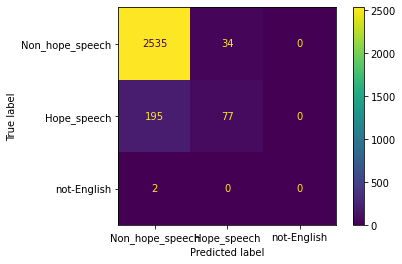

In [ ]:
lr_en_scores = print_scores(english_ytest, lr_preds)

In [ ]:
scores['english_scores']['LR'] = 0.9027153168945248

### Tamil

In [ ]:
for C in C_vals:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=C)

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5555004955401388
Testing F1 score: 0.5544014685866676

------------------------------------------------

Logistic Regression - penalty: l2 , C: 0.001 , solver : lbfgs , multi_class : auto
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

------------------------------------------------

Logistic Regression - penalty: l2 , C: 100000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5535183349851338
Testing F1 score: 0.5530587729542105

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1e-05 , solver : lbfgs , multi_class : auto
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

-----------

In [ ]:
for solver in solvers:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, solver=solver, C=1)

Logistic Regression - penalty: l2 , C: 1 , solver : newton-cg , multi_class : auto
Testing accuracy 0.5966303270564915
Testing F1 score: 0.587451155348147

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : sag , multi_class : auto
Testing accuracy 0.5966303270564915
Testing F1 score: 0.587451155348147

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : auto
Testing accuracy 0.5966303270564915
Testing F1 score: 0.587451155348147

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------



In [ ]:
for mc in multi_classes:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, multi_class=mc, C=1, solver='lbfgs')

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
Testing accuracy 0.6035678889990089
Testing F1 score: 0.5901410720264393

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------



In [ ]:
for penalty in penalties:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, penalty=penalty, solver='lbfgs', C=1, multi_class='ovr')
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, penalty=penalty, solver='saga', C=1, multi_class='ovr')

Logistic Regression - penalty: l1 , C: 1 , solver : saga , multi_class : ovr
Testing accuracy 0.595639246778989
Testing F1 score: 0.5770648757900969

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
Testing accuracy 0.6035678889990089
Testing F1 score: 0.5901410720264393

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : ovr
Testing accuracy 0.6035678889990089
Testing F1 score: 0.5901410720264393

------------------------------------------------

Logistic Regression - penalty: elasticnet , C: 1 , solver : saga , multi_class : ovr
Testing accuracy 0.6025768087215064
Testing F1 score: 0.5872734416269555

------------------------------------------------



### Results
Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr  
----------Test Scores----------

Precision: 0.5994784925831929  
Recall: 0.6035678889990089  
F1-Score: 0.5901410720264393  
Accuracy: 0.6035678889990089   

In [ ]:
lr_tamil = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='ovr')
lr_tamil_preds = lr_tamil.fit(tamil_Xtrain, tamil_ytrain).predict(tamil_Xtest)


----------Test Scores----------

Precision: 0.5994784925831929
Recall: 0.6035678889990089
F1-Score: 0.5901410720264393
Accuracy: 0.6035678889990089

                 precision    recall  f1-score   support

Non_hope_speech       0.62      0.78      0.69       998
    Hope_speech       0.58      0.46      0.51       757
    not-English       0.60      0.36      0.45       263

       accuracy                           0.60      2018
      macro avg       0.60      0.53      0.55      2018
   weighted avg       0.60      0.60      0.59      2018
 



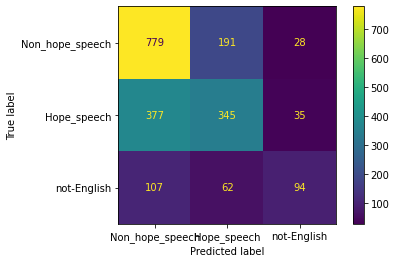

In [ ]:
lr_ta_scores = print_scores(tamil_ytest, lr_tamil_preds)

In [ ]:
scores['tamil_scores']['LR'] = 0.5901410720264393

## NB

In [ ]:
def multiNB(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, alpha=1.0, fit_prior=True):
  mnb = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
  mnb.fit(X_train, y_train)
  y_pred = mnb.predict(X_test)
  print('Multinomial Naive Bayes - alpha : {} , fit_prior : {}'.format(alpha, fit_prior))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
alphas = [1e-10, 0.2, 0.5, 0.7, 0.9, 1.0]
fit_prior_vals = [False, True]
parameters = {"alpha": [1e-10, 0.2, 0.5, 0.7, 0.9, 1.0], "fit_prior": [False, True]}

### English

In [ ]:
for alpha in alphas:
  multiNB(alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True
Testing accuracy 0.9036229335209286
Testing F1 score: 0.882731570478754

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : True
Testing accuracy 0.9053816391136124
Testing F1 score: 0.8724267329042407

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : True
Testing accuracy 0.9053816391136124
Testing F1 score: 0.8634007736541087

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : True
Testing accuracy 0.9046781568765389
Testing F1 score: 0.860437327969469

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : True
Testing accuracy 0.9043264157580021
Testing F1 score: 0.8595879391023398

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : True
Testing accuracy 0.9043264157580021
Te

In [ ]:
for alpha in alphas:
  multiNB(fit_prior= False, alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : False
Testing accuracy 0.7657404150545198
Testing F1 score: 0.8080203842848624

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : False
Testing accuracy 0.8061906436862469
Testing F1 score: 0.8393153877212848

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : False
Testing accuracy 0.8434752022511431
Testing F1 score: 0.8578698408470506

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : False
Testing accuracy 0.858248329229687
Testing F1 score: 0.8624284042208011

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False
Testing accuracy 0.8656348927189589
Testing F1 score: 0.8641500202063295

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : False
Testing accuracy 0.869152303904

### Results
Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True    
----------Test Scores----------

Precision: 0.8776676960725917  
Recall: 0.9036229335209286  
F1-Score: 0.882731570478754  
Accuracy: 0.9036229335209286  


----------Test Scores----------

Precision: 0.8776676960725917
Recall: 0.9036229335209286
F1-Score: 0.882731570478754
Accuracy: 0.9036229335209286

                 precision    recall  f1-score   support

Non_hope_speech       0.92      0.98      0.95      2569
    Hope_speech       0.50      0.18      0.27       272
    not-English       0.00      0.00      0.00         2

       accuracy                           0.90      2843
      macro avg       0.47      0.39      0.41      2843
   weighted avg       0.88      0.90      0.88      2843
 



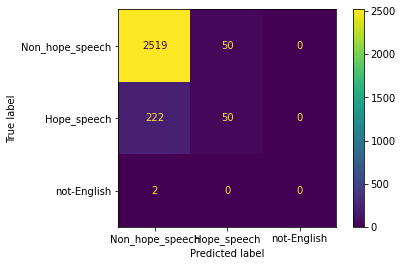

In [ ]:
mnb = MultinomialNB(alpha=1e-10, fit_prior=True)
mnb.fit(english_Xtrain, english_ytrain)
mnb_pred = mnb.predict(english_Xtest)
mnb_en_scores = print_scores(english_ytest, mnb_pred)

In [ ]:
scores['english_scores']['MNB'] = 0.882731570478754

### Tamil

In [ ]:
for alpha in alphas:
  multiNB(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True
Testing accuracy 0.6005946481665014
Testing F1 score: 0.5982228599554849

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : True
Testing accuracy 0.6065411298315163
Testing F1 score: 0.5974340286234954

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : True
Testing accuracy 0.6105054509415263
Testing F1 score: 0.5920146972801057

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : True
Testing accuracy 0.6144697720515362
Testing F1 score: 0.5905980556028777

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : True
Testing accuracy 0.6060455896927651
Testing F1 score: 0.5777800788793289

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : True
Testing accuracy 0.6060455896927651


In [ ]:
for alpha in alphas:
  multiNB(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, fit_prior= False, alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : False
Testing accuracy 0.5832507433102081
Testing F1 score: 0.5836156949886772

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : False
Testing accuracy 0.5887016848364718
Testing F1 score: 0.5887961623445258

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : False
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5967150115410065

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : False
Testing accuracy 0.6065411298315163
Testing F1 score: 0.6033737799696764

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False
Testing accuracy 0.6129831516352825
Testing F1 score: 0.6086350551149339

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : False
Testing accuracy 0.61248761149

### Results
Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False  
----------Test Scores----------

Precision: 0.6079969472854241  
Recall: 0.6129831516352825  
F1-Score: 0.6086350551149339  
Accuracy: 0.6129831516352825  


----------Test Scores----------

Precision: 0.6079969472854241
Recall: 0.6129831516352825
F1-Score: 0.6086350551149339
Accuracy: 0.6129831516352825

                 precision    recall  f1-score   support

Non_hope_speech       0.65      0.72      0.69       998
    Hope_speech       0.57      0.52      0.55       757
      not-Tamil       0.55      0.45      0.49       263

       accuracy                           0.61      2018
      macro avg       0.59      0.57      0.58      2018
   weighted avg       0.61      0.61      0.61      2018
 



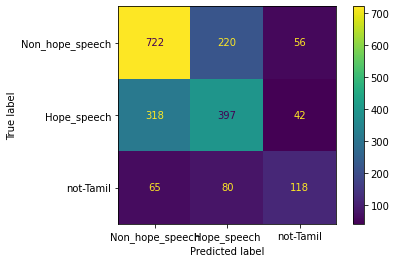

In [28]:
mnb_tamil = MultinomialNB(alpha=0.9, fit_prior=False)
mnb_tamil.fit(tamil_Xtrain, tamil_ytrain)
mnb_tamil_pred = mnb_tamil.predict(tamil_Xtest)
mnb_ta_scores = print_scores(tamil_ytest, mnb_tamil_pred, labels=tamil_labels)

In [ ]:
scores['tamil_scores']['MNB'] = 0.6086350551149339

## SVM

In [ ]:
def svm_clf(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, kernel='rbf', C=1, gamma='scale', decision_function_shape = 'ovr'):
  clf = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape=decision_function_shape)
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print('SVM - kernel : {} , C : {} , gamma : {} , decision function shape : {}'.format(kernel, C, gamma, decision_function_shape))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
C_vals = [1, 1e3, 1e-3, 1e5, 1e-5]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo', 'ovr']

### English

In [ ]:
for C in C_vals:
  svm_clf(C=C)

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9169890960253254
Testing F1 score: 0.8927910434135883

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9236721772775237
Testing F1 score: 0.911830822935761

------------------------------------------------

SVM - kernel : rbf , C : 0.001 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

------------------------------------------------

SVM - kernel : rbf , C : 100000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9236721772775237
Testing F1 score: 0.911830822935761

------------------------------------------------

SVM - kernel : rbf , C : 1e-05 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

-----------------------------------------

In [ ]:
for kernel in kernels:
  svm_clf(C=1e3, kernel=kernel)

SVM - kernel : linear , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.8747801618009146
Testing F1 score: 0.8778756490395483

------------------------------------------------

SVM - kernel : poly , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9138234259584945
Testing F1 score: 0.8860232215578108

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9236721772775237
Testing F1 score: 0.911830822935761

------------------------------------------------

SVM - kernel : sigmoid , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.8593035525852972
Testing F1 score: 0.8648453348914917

------------------------------------------------



In [ ]:
for g in gamma:
  svm_clf(C=1e3, kernel='rbf' , gamma=g) 

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9236721772775237
Testing F1 score: 0.911830822935761

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : auto , decision function shape : ovr
Testing accuracy 0.9064368624692226
Testing F1 score: 0.8658487135210791

------------------------------------------------



In [ ]:
for dfs in decision_function_shape:
  svm_clf(C=1e3, kernel='rbf' , gamma='scale' , decision_function_shape=dfs)

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovo
Testing accuracy 0.9236721772775237
Testing F1 score: 0.911830822935761

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9236721772775237
Testing F1 score: 0.911830822935761

------------------------------------------------



### Results
SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr  
----------Test Scores----------

Precision: 0.9122564681481131  
Recall: 0.9236721772775237  
F1-Score: 0.911830822935761  
Accuracy: 0.9236721772775237  


----------Test Scores----------

Precision: 0.9122564681481131
Recall: 0.9236721772775237
F1-Score: 0.911830822935761
Accuracy: 0.9236721772775237

                 precision    recall  f1-score   support

Non_hope_speech       0.93      0.98      0.96      2569
    Hope_speech       0.71      0.36      0.47       272
    not-English       0.00      0.00      0.00         2

       accuracy                           0.92      2843
      macro avg       0.55      0.45      0.48      2843
   weighted avg       0.91      0.92      0.91      2843
 



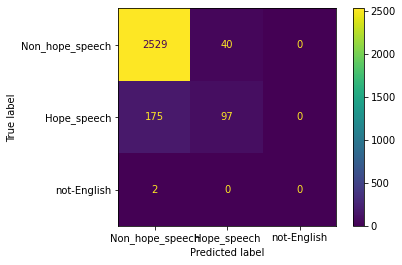

In [ ]:
svm = SVC(kernel='rbf', C=1e3, gamma='scale', decision_function_shape='ovr')
svm.fit(english_Xtrain, english_ytrain)
svm_pred = svm.predict(english_Xtest)
svm_en_scores = print_scores(english_ytest, svm_pred)

In [ ]:
scores['english_scores']['SVM'] = 0.911830822935761

### Tamil

In [ ]:
for C in C_vals:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=C)

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6110009910802775
Testing F1 score: 0.5945001708881719

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.578790882061447
Testing F1 score: 0.5734611754284697

------------------------------------------------

SVM - kernel : rbf , C : 0.001 , gamma : scale , decision function shape : ovr
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

------------------------------------------------

SVM - kernel : rbf , C : 100000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.5782953419226957
Testing F1 score: 0.5730156563452314

------------------------------------------------

SVM - kernel : rbf , C : 1e-05 , gamma : scale , decision function shape : ovr
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

--------------------------------

In [ ]:
for kernel in kernels:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=1, kernel=kernel)

SVM - kernel : linear , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6055500495540139
Testing F1 score: 0.5966087718788537

------------------------------------------------

SVM - kernel : poly , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5578855281625477

------------------------------------------------

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6110009910802775
Testing F1 score: 0.5945001708881719

------------------------------------------------

SVM - kernel : sigmoid , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6045589692765114
Testing F1 score: 0.5930569646079785

------------------------------------------------



In [ ]:
for g in gamma:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=1, kernel= 'rbf', gamma=g)

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6110009910802775
Testing F1 score: 0.5945001708881719

------------------------------------------------

SVM - kernel : rbf , C : 1 , gamma : auto , decision function shape : ovr
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

------------------------------------------------



In [ ]:
for dfs in decision_function_shape:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=1, kernel= 'rbf', gamma= 'scale', decision_function_shape=dfs)

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovo
Testing accuracy 0.6110009910802775
Testing F1 score: 0.5945001708881719

------------------------------------------------

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6110009910802775
Testing F1 score: 0.5945001708881719

------------------------------------------------



### Results
SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr  
----------Test Scores----------

Precision: 0.6085154324581377  
Recall: 0.6110009910802775  
F1-Score: 0.5945001708881719  
Accuracy: 0.6110009910802775  


----------Test Scores----------

Precision: 0.6085154324581377
Recall: 0.6110009910802775
F1-Score: 0.5945001708881719
Accuracy: 0.6110009910802775

                 precision    recall  f1-score   support

Non_hope_speech       0.62      0.81      0.70       998
    Hope_speech       0.60      0.43      0.50       757
    not-English       0.60      0.37      0.46       263

       accuracy                           0.61      2018
      macro avg       0.61      0.54      0.55      2018
   weighted avg       0.61      0.61      0.59      2018
 



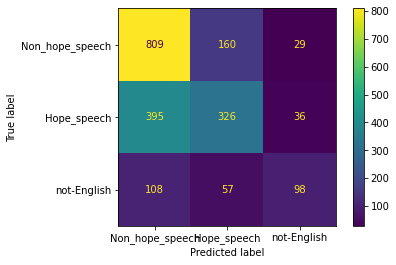

In [ ]:
svm_ta = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')
svm_ta.fit(tamil_Xtrain, tamil_ytrain)
svm_ta_pred = svm_ta.predict(tamil_Xtest)
svm_ta_scores = print_scores(tamil_ytest, svm_ta_pred)

In [ ]:
scores['tamil_scores']['SVM'] = 0.5945001708881719

## Ensemble

In [ ]:
def ensemble(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, clf1=LogisticRegression(), clf2=SVC(), clf3=MultinomialNB(), voting='hard', plot=False):
  clf4 = RandomForestClassifier(n_estimators=100, random_state=1)
  ensemble_clf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2), ('mnb', clf3), ('rfc', clf4)], voting=voting)
  ensemble_clf.fit(X_train, y_train)
  y_pred = ensemble_clf.predict(X_test)
  print('Ensemble method - voting : {}'.format(voting))
  if plot==False:
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  else:
    print_scores(y_test, y_pred)
  print('\n------------------------------------------------\n')

In [ ]:
votings = ['hard', 'soft']

### English

In [ ]:
# Logistic Regression - penalty: l1 , C: 1 , solver : saga , multi_class : multinomial
english_LR = LogisticRegression(penalty='l1', C=1, solver='saga', multi_class='multinomial', max_iter=1000)
# SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
english_SVM = SVC(kernel='rbf', C=1e3, gamma='scale', decision_function_shape='ovr', probability=True)
# Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True
english_NB = MultinomialNB(alpha=1e-10, fit_prior=True)

In [ ]:
for voting in votings:
  ensemble(voting=voting, clf1=english_LR, clf2=english_SVM, clf3=english_NB)

Ensemble method - voting : hard
Testing accuracy 0.9162856137882518
Testing F1 score: 0.891104053336387

------------------------------------------------

Ensemble method - voting : soft
Testing accuracy 0.9194512838550827
Testing F1 score: 0.8989564196299314

------------------------------------------------



### Results
Ensemble method - voting : soft  
----------Test Scores----------

Precision: 0.909004425474366  
Recall: 0.9194512838550827  
F1-Score: 0.8989564196299314  
Accuracy: 0.9194512838550827  

Ensemble method - voting : soft

----------Test Scores----------

Precision: 0.909004425474366
Recall: 0.9194512838550827
F1-Score: 0.8989564196299314
Accuracy: 0.9194512838550827

                 precision    recall  f1-score   support

Non_hope_speech       0.92      0.99      0.96      2569
    Hope_speech       0.78      0.23      0.36       272
    not-English       0.00      0.00      0.00         2

       accuracy                           0.92      2843
      macro avg       0.57      0.41      0.44      2843
   weighted avg       0.91      0.92      0.90      2843
 


------------------------------------------------



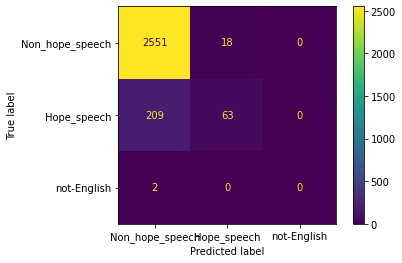

In [ ]:
ensemble_en = ensemble(voting='soft', clf1=english_LR, clf2=english_SVM, clf3=english_NB, plot=True)

In [ ]:
scores['english_scores']['Ensemble'] = 0.8989564196299314

### Tamil

In [ ]:
# Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
tamil_LR = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='ovr', max_iter=1000)
# SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
tamil_SVM = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr', probability=True)
# Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False
tamil_NB = MultinomialNB(alpha=0.9, fit_prior=False)

In [ ]:
for voting in votings:
  ensemble(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, voting=voting, clf1=tamil_LR, clf2=tamil_SVM, clf3=tamil_NB)

Ensemble method - voting : hard
Testing accuracy 0.6075322101090188
Testing F1 score: 0.5900089674939608

------------------------------------------------

Ensemble method - voting : soft
Testing accuracy 0.6144697720515362
Testing F1 score: 0.6035640056105799

------------------------------------------------



### Results
Ensemble method - voting : soft  
----------Test Scores----------

Precision: 0.6094846174804791  
Recall: 0.6144697720515362  
F1-Score: 0.6035640056105799  
Accuracy: 0.6144697720515362  

Ensemble method - voting : soft

----------Test Scores----------

Precision: 0.6094846174804791
Recall: 0.6144697720515362
F1-Score: 0.6035640056105799
Accuracy: 0.6144697720515362

                 precision    recall  f1-score   support

Non_hope_speech       0.63      0.78      0.70       998
    Hope_speech       0.59      0.47      0.52       757
    not-English       0.58      0.41      0.48       263

       accuracy                           0.61      2018
      macro avg       0.60      0.55      0.57      2018
   weighted avg       0.61      0.61      0.60      2018
 


------------------------------------------------



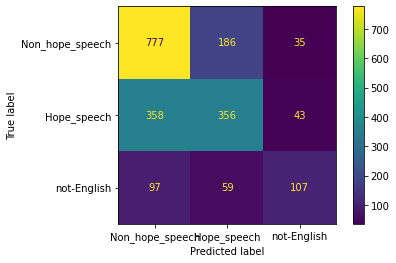

In [ ]:
ensemble_ta = ensemble(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, voting='soft', clf1=tamil_LR, clf2=tamil_SVM, clf3=tamil_NB, plot=True)

In [ ]:
scores['tamil_scores']['Ensemble'] = 0.6035640056105799

## Plots

### English

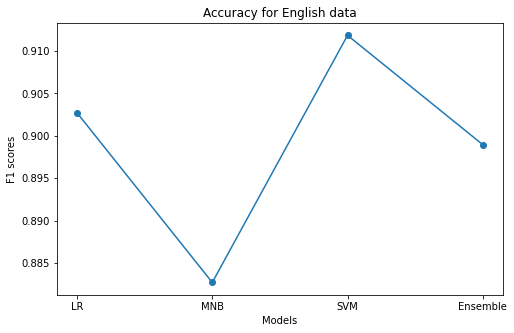

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(scores['english_scores'].keys()), list(scores['english_scores'].values()), 'o-')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Accuracy for English data')
plt.show()

### Tamil

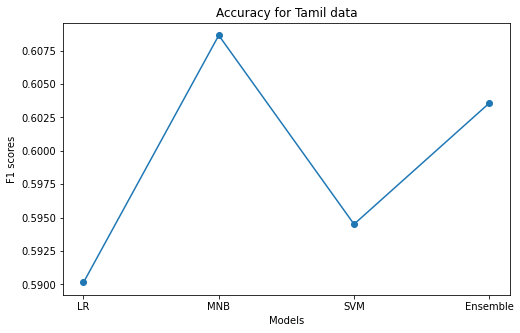

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(scores['tamil_scores'].keys()), list(scores['tamil_scores'].values()), 'o-')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Accuracy for Tamil data')
plt.show()

# DL models

## Libraries

In [31]:
pip install keras-tuner

In [32]:
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten, Dense, Embedding, Lambda, Input, Dropout
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
# from livelossplot import PlotLossesKeras
import keras_tuner as kt
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from urllib.request import urlopen
import gzip
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### English

In [33]:
english_Xtrain = np.array(english_hope_train["texts"])
english_ytrain = np.array(english_hope_train["enc_label"])
english_Xtest = np.array(english_hope_test["texts"])
english_ytest = np.array(english_hope_test["enc_label"])

In [34]:
english_tokenizer = Tokenizer(
                        num_words=1000,
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                        lower=True, split=' ', oov_token='<oov>'
                    )
english_tokenizer.fit_on_texts(english_Xtrain)

In [35]:
english_vocab = english_tokenizer.word_index
print("No of words in English Tokenizer: ", len(english_vocab))
english_vocab_len = len(english_vocab) + 1
print("English vocabulary size: ", english_vocab_len)

No of words in English Tokenizer:  15960
English vocabulary size:  15961


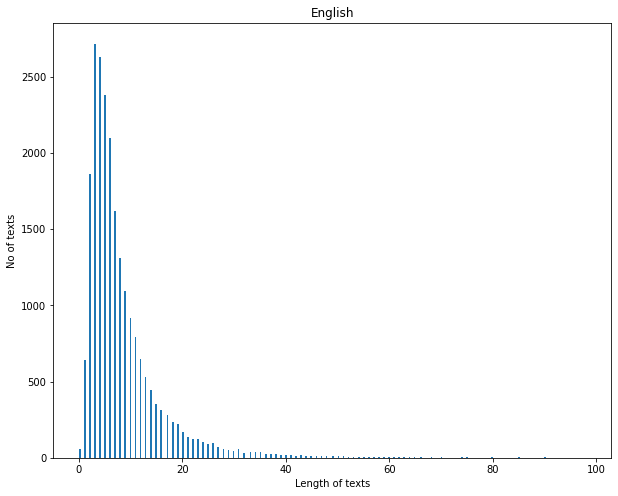

In [36]:
plt.figure(figsize=(10,8))
plt.hist([len(text.split()) for text in english_Xtrain], bins=300)
plt.xlabel('Length of texts')
plt.ylabel('No of texts')
plt.title('English')
plt.show()

In [37]:
max([len(text.split()) for text in english_Xtrain])

98

In [38]:
english_maxlen = 100

In [39]:
english_train_seq = english_tokenizer.texts_to_sequences(english_Xtrain)
english_train_pad_seq = pad_sequences(english_train_seq, maxlen=english_maxlen, padding='post', value=0.0)
print("No of train sequences:", english_train_pad_seq.shape)

english_test_seq = english_tokenizer.texts_to_sequences(english_Xtest)
english_test_pad_seq = pad_sequences(english_test_seq, maxlen=english_maxlen, padding='post', value=0.0)
print("No of test sequences:", english_test_pad_seq.shape)

No of train sequences: (22762, 100)
No of test sequences: (2843, 100)


### Tamil

In [40]:
tamil_Xtrain = np.array(tamil_hope_train["texts"])
tamil_ytrain = np.array(tamil_hope_train["enc_label"])
tamil_Xtest = np.array(tamil_hope_test["texts"])[:2016]
tamil_ytest = np.array(tamil_hope_test["enc_label"])[:2016]

In [41]:
tamil_tokenizer = Tokenizer(
                        num_words=1000,
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                        lower=True, split=' ', oov_token='<oov>'
                    )
tamil_tokenizer.fit_on_texts(tamil_Xtrain)

In [42]:
tamil_vocab = tamil_tokenizer.word_index
print("No of words in Tamil Tokenizer: ", len(tamil_vocab))
tamil_vocab_len = len(tamil_vocab) + 1
print("Tamil vocabulary size: ", tamil_vocab_len)

No of words in Tamil Tokenizer:  31414
Tamil vocabulary size:  31415


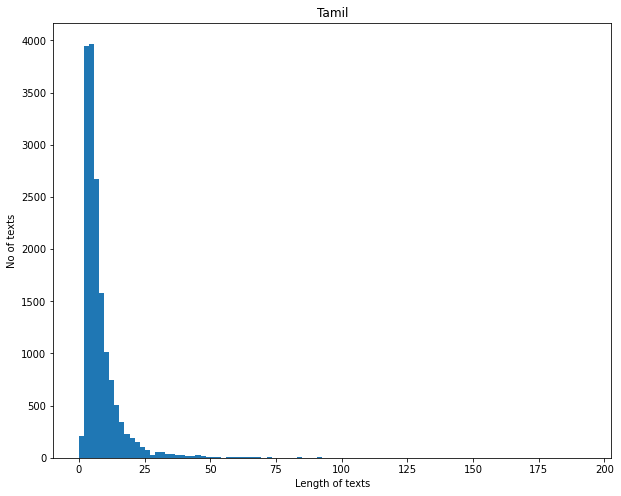

In [43]:
plt.figure(figsize=(10,8))
plt.hist([len(text.split()) for text in tamil_Xtrain], bins=100)
plt.xlabel('Length of texts')
plt.ylabel('No of texts')
plt.title('Tamil')
plt.show()

In [44]:
max([len(text.split()) for text in tamil_Xtrain])

193

In [45]:
tamil_maxlen = 100

In [46]:
tamil_train_seq = tamil_tokenizer.texts_to_sequences(tamil_Xtrain)
tamil_train_pad_seq = pad_sequences(tamil_train_seq, maxlen=tamil_maxlen, padding='post', value=0.0)
print("No of train sequences:", tamil_train_pad_seq.shape)

tamil_test_seq = tamil_tokenizer.texts_to_sequences(tamil_Xtest)
tamil_test_pad_seq = pad_sequences(tamil_test_seq, maxlen=tamil_maxlen, padding='post', value=0.0)
print("No of test sequences:", tamil_test_pad_seq.shape)

No of train sequences: (16160, 100)
No of test sequences: (2016, 100)


## Embeddings

In [ ]:
english_vocab_len

15961

In [ ]:
def load_embed_matrix(f, vocab_size=english_vocab_len, embed_vec_len=300, word_index=english_vocab, saved_embeddings='English_FT_vec.npy'):
  embedding_index = {}
  count = 0
  for line in f:
    values = line.split()
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
  embedding_matrix = np.zeros((vocab_size, embed_vec_len))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      count += 1
  print(count,'OOV words')
  np.save(saved_embeddings, embedding_matrix)
  return embedding_matrix, embedding_index

In [ ]:
english_ft_vec = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'))
english_ft_matrix, english_ft_index = load_embed_matrix(english_ft_vec)

6765 OOV words


In [ ]:
english_ft_matrix.shape

(15961, 300)

In [ ]:
english_ft_matrix = np.load('English_FT_vec.npy')

In [ ]:
tamil_ft_vec = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz'))
tamil_ft_matrix, tamil_ft_index = load_embed_matrix(f=tamil_ft_vec, vocab_size=tamil_vocab_len, word_index=tamil_vocab, saved_embeddings='Tamil_FT_vec.npy')

25365 OOV words


In [ ]:
tamil_ft_matrix.shape

(31415, 300)

In [ ]:
# tamil_ft_matrix = np.load('Tamil_FT_vec.npy')

## Functions

In [47]:
# Returns (Trained Model, Predictions, History, Scores)

def create_model(Xtrain=english_train_pad_seq, ytrain=english_ytrain, Xtest=english_test_pad_seq, ytest=english_ytest, 
                  lr=0.001, batch_size=32, epochs=30, val_split=0.2, model=None, saved_model="En_CNN_BiLSTMModel.h5", fit=True, history_file=None, plot=False, labels=english_labels):

  history = None
  if fit==True:
    if model==None:
      model = load_model(saved_model)
    else:
      # Compiling model
      model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

    print('\n----------Fitting Model----------\n')
    chkpt = ModelCheckpoint(saved_model, monitor='val_acc',verbose=1, save_best_only=True, save_weights_only=False, mode='max')

    early_stopping = EarlyStopping(monitor='acc', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=True)

    if plot==True:
      callbacks = [PlotLossesKeras(), chkpt, early_stopping]
    else:
      callbacks = [chkpt, early_stopping]

    # Fitting Model
    history = model.fit(
        x=Xtrain,
        y=ytrain,
        validation_split=val_split,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=True
    )

    np.save(saved_model[:-8]+'History.npy',history.history)
  
  if history_file!=None:
    history = np.load(history_file,allow_picke=True)

  # Loading Model
  loadedModel = load_model(saved_model)

  print('\n----------Model Summary----------\n')
  print(loadedModel.summary())

  # Predicting
  ypred = np.argmax(loadedModel.predict(Xtest), axis=-1)

  print('\n----------Test Scores----------\n')
  # Scores
  scores = {'F1-Score': f1_score(ytest, ypred, average = 'weighted'), 'Accuracy': accuracy_score(ytest, ypred),
            'Precision': precision_score(ytest, ypred, average = 'weighted'), 'Recall': recall_score(ytest, ypred, average = 'weighted'), 
            'Classification Report': classification_report(ytest, ypred, labels=[0,1,2], target_names=labels),
            'Confusion Matrix Display': ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=labels)}
  print("Precision: {}".format(scores['Precision']))
  print("Recall: {}".format(scores['Recall']))
  print("F1-Score: {}".format(scores['F1-Score']))
  print("Accuracy: {}\n".format(scores['Accuracy']))
  print(scores['Classification Report'],'\n')
  scores['Confusion Matrix Display']

  return loadedModel, ypred, history, scores

In [ ]:
def embedding_layer(input_dim=english_vocab_len, output_dim=300, input_length=english_maxlen, embedding=False, embedding_matrix=english_ft_matrix):
  if(embedding==False):
    return Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)
  output_dim = embedding_matrix.shape[1]
  return Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, weights=[embedding_matrix], trainable=True)

In [ ]:
english_elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

def En_ELMoEmbedding(x):
  return english_elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [ ]:
tamil_elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

def Ta_ELMoEmbedding(x):
  return english_elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [ ]:
def plot_history(H, path):
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure(figsize=(10,7))
    plt.plot(H["loss"], label="train_loss")
    plt.plot(H["val_loss"], label="val_loss")
    plt.plot(H["acc"], label="train_acc")
    plt.plot(H["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    if os.path.exists('/content/plots')==False:
      os.mkdir('/content/plots')
    plt.savefig(path)

In [ ]:
class build_model(kt.HyperModel):
  def __init__(self, lang='EN', embeddings='KE', elmo_embed=None, trainable=True):
    self.lang=lang
    self.embeddings=embeddings
    self.elmo_embed=elmo_embed
    self.trainable=trainable
  
  def build(self, hp):
    model = keras.Sequential()

    output_dim=hp.Int("embed_output_dim", min_value=100, max_value=300, step=50)
    if self.embeddings=='KE':
      if self.lang=='EN':
        embed_layer = Embedding(input_dim=english_vocab_len, output_dim=output_dim, input_length=english_maxlen, trainable=self.trainable)
      else:
        embed_layer = Embedding(input_dim=tamil_vocab_len, output_dim=output_dim, input_length=tamil_maxlen, trainable=self.trainable)
    elif self.embeddings=='FT':
      if self.lang=='EN':
        embed_layer = Embedding(input_dim=english_vocab_len, output_dim=300, input_length=english_maxlen, weights=[english_ft_matrix], trainable=self.trainable)
      else:
        embed_layer = Embedding(input_dim=tamil_vocab_len, output_dim=300, input_length=tamil_maxlen, weights=[tamil_ft_matrix], trainable=self.trainable)
    elif self.embeddings=='ELMo':
      embed_layer = self.elmo_embed

    model.add(embed_layer)
    model.add(Conv1D(filters = hp.Int("conv_filters", min_value=64, max_value=256, step=64), kernel_size = hp.Choice('conv_kernel_size', [3, 5, 10]), activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Choice('maxpool_size', [2, 5, 10]), strides=hp.Choice('maxpool_strides', [1, 2, 3])))
    model.add(Bidirectional(LSTM(units = hp.Int("lstm_units", min_value=32, max_value=128, step=32),return_sequences=False,dropout = hp.Choice('dropout_value', [0.1, 0.2, 0.3]))))
    model.add(Dense(3 , activation='softmax'))

    lr = hp.Choice('learning_rate', [0.001, 0.00146, 0.0001, 0.0005])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'], run_eagerly=True)
    return model

In [ ]:
def tune_model(myhypermodel=build_model(), max_trials=5, saved_model="En_CNN_BiLSTMModel.h5", Xtrain=english_train_pad_seq, 
               ytrain=english_ytrain, Xtest=english_test_pad_seq, ytest=english_ytest, epochs=30, batch_size=64, val_split=0.2, labels=english_labels):
  print("\n------BayesianOptimization tuner------\n")
  tuner = kt.BayesianOptimization(
    myhypermodel,
    objective='val_acc',
    max_trials=max_trials,
    directory='output',
    project_name=saved_model[:-8])
  
  chkpt = ModelCheckpoint(saved_model, monitor='val_acc',verbose=1, save_best_only=True, save_weights_only=False, mode='max')
  early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=True)

  tuner.search(Xtrain, ytrain, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_split=val_split)

  print("\n------Best hyperparameters found------\n")
  bestHP = tuner.get_best_hyperparameters()[0]
  print("Optimal output dimension of Embeddings: {}".format(bestHP.get("embed_output_dim")))
  print("Optimal number of filters in conv layer: {}".format(bestHP.get("conv_filters")))
  print("Optimal kernel size in conv layer: {}".format(bestHP.get("conv_kernel_size")))
  print("Optimal pool size in maxpooling layer: {}".format(bestHP.get("maxpool_size")))
  print("Optimal strides in maxpooling layer: {}".format(bestHP.get("maxpool_strides")))
  print("Optimal number of units in bilstm layer: {}".format(bestHP.get("lstm_units")))
  print("Optimal dropout value: {}".format(bestHP.get("dropout_value")))
  print("Optimal learning rate: {}".format(bestHP.get("learning_rate")))

  # build the best model and train it
  print("\n------Training the best model------\n")
  model = tuner.hypermodel.build(bestHP)
  print(model.summary())

  H = model.fit(Xtrain, ytrain, validation_split=val_split, batch_size=batch_size, epochs=epochs, callbacks=[chkpt, early_stopping], verbose=1)
  np.save(saved_model[:-8]+'History.npy',H.history)
  
  # evaluate the network
  print("\n------Evaluating the best model------\n")
  ypred = np.argmax(model.predict(Xtest, batch_size=batch_size), axis=-1)

  scores = {'F1-Score': f1_score(ytest, ypred, average = 'weighted'), 'Accuracy': accuracy_score(ytest, ypred),
          'Precision': precision_score(ytest, ypred, average = 'weighted'), 'Recall': recall_score(ytest, ypred, average = 'weighted'), 
          'Classification Report': classification_report(ytest, ypred, labels=[0,1,2], target_names=labels),
          'Confusion Matrix Display': ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=labels)}

  print("Precision: {}".format(scores['Precision']))
  print("Recall: {}".format(scores['Recall']))
  print("F1-Score: {}".format(scores['F1-Score']))
  print("Accuracy: {}\n".format(scores['Accuracy']))
  print(scores['Classification Report'],'\n')
  print(scores['Confusion Matrix Display'])

  # generate the training loss/accuracy plot
  plot_history(H.history, '/content/plots/'+saved_model[:-8]+'History.png')

  return tuner, model, H, ypred, scores

## Hyperparamter tuning
**links**  
https://www.tensorflow.org/tutorials/keras/keras_tuner  
https://keras.io/api/keras_tuner/  

### English    
  
Trial 12 Complete [00h 20m 43s]  
val_acc: 0.9171974658966064  

Best val_acc So Far: 0.9185152649879456  

------Best hyperparameters found------  
  
Optimal output dimension of Embeddings: 150  
Optimal number of filters in conv layer: 256  
Optimal kernel size in conv layer: 10  
Optimal pool size in maxpooling layer: 2  
Optimal strides in maxpooling layer: 3  
Optimal number of units in bilstm layer: 32  
Optimal dropout value: 0.3  
Optimal learning rate: 0.001  
    
------Evaluating the best model------

Precision: 0.9038597812579954  
Recall: 0.9173408371438622  
F1-Score: 0.9064662190411468  
Accuracy: 0.9173408371438622

In [ ]:
En_CNN_BiLSTMModel = build_model()

Trial 12 Complete [00h 20m 43s]
val_acc: 0.9171974658966064

Best val_acc So Far: 0.9185152649879456
Total elapsed time: 00h 41m 26s
INFO:tensorflow:Oracle triggered exit

------Best hyperparameters found------

Optimal output dimension of Embeddings: 150
Optimal number of filters in conv layer: 256
Optimal kernel size in conv layer: 10
Optimal pool size in maxpooling layer: 2
Optimal strides in maxpooling layer: 3
Optimal number of units in bilstm layer: 32
Optimal dropout value: 0.3
Optimal learning rate: 0.001

------Training the best model------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 150)          2394150   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 256)           384256    
_________________________________________________________________
max_pooling1d_1 (MaxPooli

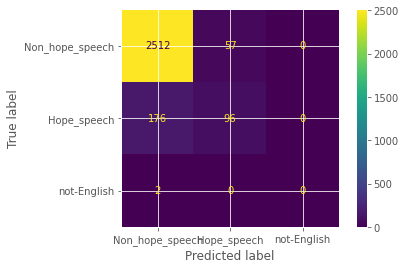

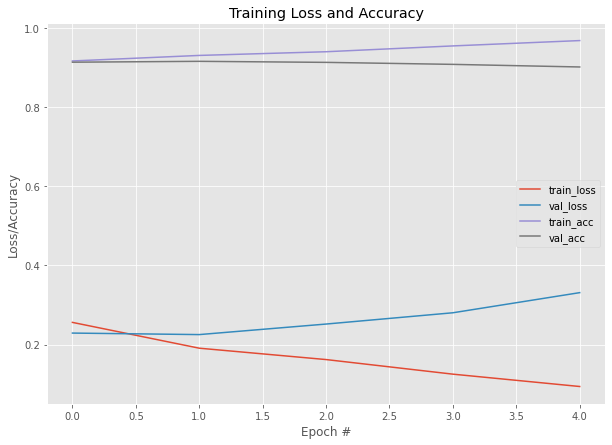

In [ ]:
En_CNN_BiLSTM = tune_model(myhypermodel=En_CNN_BiLSTMModel, max_trials=12)

### English with FastText    
Trial 4 Complete [01h 27m 10s]  
val_acc: 0.9143421649932861  
  
Best val_acc So Far: 0.9152207374572754  
  
------Best hyperparameters found------  
  
Optimal output dimension of Embeddings: 200  
Optimal number of filters in conv layer: 64  
Optimal kernel size in conv layer: 3  
Optimal pool size in maxpooling layer: 10  
Optimal strides in maxpooling layer: 2  
Optimal number of units in bilstm layer: 96  
Optimal dropout value: 0.2  
Optimal learning rate: 0.0005  
    
------Evaluating the best model------  
  
Precision: 0.8979458485631328  
Recall: 0.9138234259584945  
F1-Score: 0.9007452486617177  
Accuracy: 0.9138234259584945

In [ ]:
En_FT_CNN_BiLSTMModel = build_model(embeddings='FT')

Trial 4 Complete [01h 27m 10s]
val_acc: 0.9143421649932861

Best val_acc So Far: 0.9152207374572754
Total elapsed time: 03h 12m 16s
INFO:tensorflow:Oracle triggered exit

------Best hyperparameters found------

Optimal output dimension of Embeddings: 200
Optimal number of filters in conv layer: 64
Optimal kernel size in conv layer: 3
Optimal pool size in maxpooling layer: 10
Optimal strides in maxpooling layer: 2
Optimal number of units in bilstm layer: 96
Optimal dropout value: 0.2
Optimal learning rate: 0.0005

------Training the best model------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          4788300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 64)            57664     
_________________________________________________________________
max_pooling1d_1 (MaxPoolin

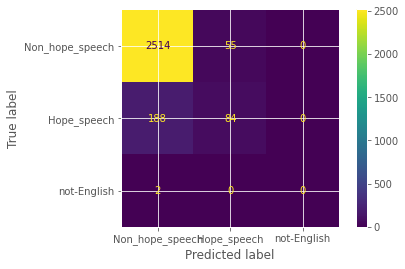

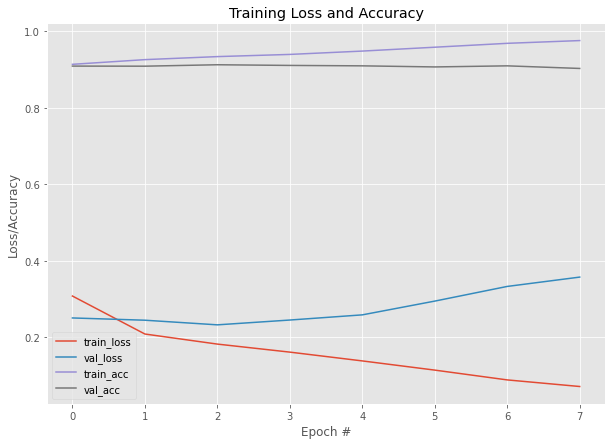

In [ ]:
En_FT_CNN_BiLSTM = tune_model(myhypermodel=En_FT_CNN_BiLSTMModel, max_trials=4, saved_model="En_FT_CNN_BiLSTMModel.h5")

### English with ELMo

In [ ]:
En_ELMo_CNN_BiLSTMModel = build_model(embeddings='ELMo', elmo_embed=Lambda(En_ELMoEmbedding, output_shape=(1024, )))

In [ ]:
with tf.Session() as session:
    tf.keras.backend.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    En_ELMo_CNN_BiLST = tune_model(myhypermodel=En_ELMo_CNN_BiLSTMModel, saved_model="En_ELMo_CNN_BiLSTMModel.h5")
    session.close()

### Tamil    

Trial 5 Complete [01h 03m 09s]
val_acc: 0.5943688154220581

Best val_acc So Far: 0.6011757254600525

------Best hyperparameters found------

Optimal output dimension of Embeddings: 100  
Optimal number of filters in conv layer: 128  
Optimal kernel size in conv layer: 10  
Optimal pool size in maxpooling layer: 10  
Optimal strides in maxpooling layer: 1  
Optimal number of units in bilstm layer: 32  
Optimal dropout value: 0.3  
Optimal learning rate: 0.001  

------Evaluating the best model------

Precision: 0.6018376335451376  
Recall: 0.6016865079365079  
F1-Score: 0.5861303498902185  
Accuracy: 0.6016865079365079

In [ ]:
Ta_CNN_BiLSTMModel = build_model(lang='TA')

Trial 5 Complete [01h 03m 09s]
val_acc: 0.5943688154220581

Best val_acc So Far: 0.6011757254600525
Total elapsed time: 04h 46m 06s
INFO:tensorflow:Oracle triggered exit

------Best hyperparameters found------

Optimal output dimension of Embeddings: 100
Optimal number of filters in conv layer: 128
Optimal kernel size in conv layer: 10
Optimal pool size in maxpooling layer: 10
Optimal strides in maxpooling layer: 1
Optimal number of units in bilstm layer: 32
Optimal dropout value: 0.3
Optimal learning rate: 0.001

------Training the best model------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3141500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 128)           128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooli

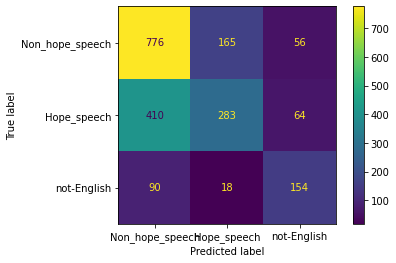

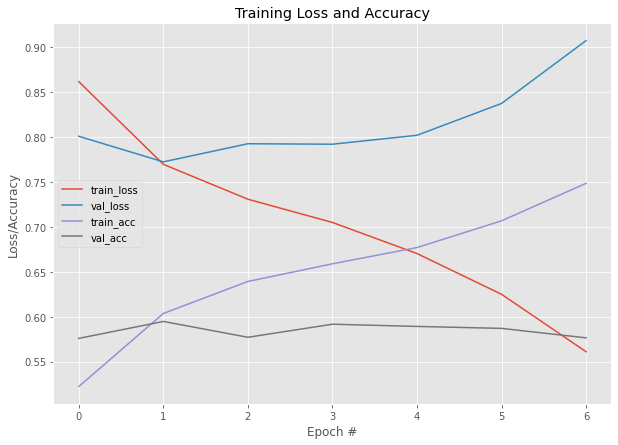

In [ ]:
Ta_CNN_BiLSTM = tune_model(myhypermodel=Ta_CNN_BiLSTMModel, saved_model="Ta_CNN_BiLSTMModel.h5", Xtrain=tamil_train_pad_seq, 
               ytrain=tamil_ytrain, Xtest=tamil_test_pad_seq, ytest=tamil_ytest)

## CNN+BiLSTM Models

In [ ]:
En_CNN_BiLSTMModel = tf.keras.models.Sequential([
          embedding_layer(),
          Conv1D(128, 5, activation='relu'),
          MaxPooling1D(5),
          Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
          Flatten(),
          Dense(3 , activation='softmax')
        ])

In [ ]:
En_FT_CNN_BiLSTMModel = tf.keras.models.Sequential([
            embedding_layer(embedding=True),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(5),
            Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
            Flatten(),
            Dense(3 , activation='softmax')
          ])

In [ ]:
Ta_CNN_BiLSTMModel = tf.keras.models.Sequential([
          embedding_layer(),
          Conv1D(128, 5, activation='relu'),
          MaxPooling1D(5),
          Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
          Flatten(),
          Dense(3 , activation='softmax')
        ])

In [ ]:
Ta_FT_CNN_BiLSTMModel = tf.keras.models.Sequential([
            embedding_layer(input_dim=tamil_vocab_len, input_length=tamil_maxlen, embedding=True, embedding_matrix=tamil_ft_matrix),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(5),
            Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
            Flatten(),
            Dense(3 , activation='softmax')
          ])

### English
---
Train Accuracy: 0.9856  
Validation Accuracy: 0.8891  
----------Test Scores----------  
Precision: 0.8975  
Recall: 0.9124  
F1-Score: 0.9013  
Accuracy: 0.9124  


----------Model Summary----------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1596100   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 19, 64)           41216     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1216)              0         
                                                                 
 dense (Dense)      

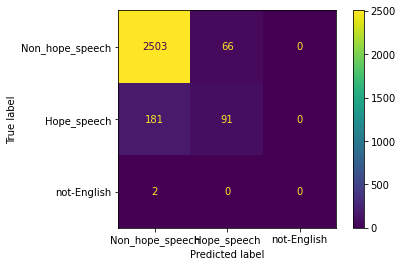

In [ ]:
En_CNN_BiLSTM = create_model(model=En_CNN_BiLSTMModel, fit=False)

In [ ]:
scores['english_scores']['En_CNN_BiLSTM'] = 0.9013

### English with FastText  
---
Train Accuracy: 0.915  
Validation Accuracy: 0.903  
----------Test Scores----------  
Precision: 0.8905   
Recall: 0.9103   
F1-Score: 0.8926   
Accuracy: 0.9103   


----------Model Summary----------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          4788300   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 19, 64)           41216     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1216)              0         
                                                                 
 dense_1 (Dense)  

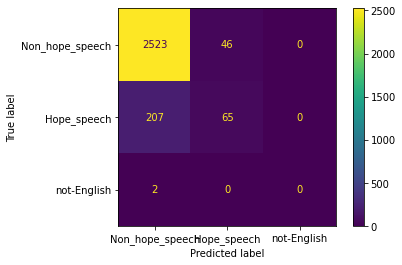

In [ ]:
En_FT_CNN_BiLSTM = create_model(model=En_FT_CNN_BiLSTMModel, saved_model='En_FT_CNN_BiLSTMModel.h5', fit=False)

In [ ]:
scores['english_scores']['En_FT_CNN_BiLSTM'] = 0.8926

### Tamil
---
Train Accuracy: 0.895  
Validation Accuracy: 0.596   
----------Test Scores----------  
Precision: 0.6075  
Recall: 0.6090  
F1-Score: 0.5997  
Accuracy: 0.6090  


----------Model Summary----------

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          1596100   
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 19, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 19, 64)           41216     
 onal)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1216)              0         
                                                                 
 dense_10 (Dense)

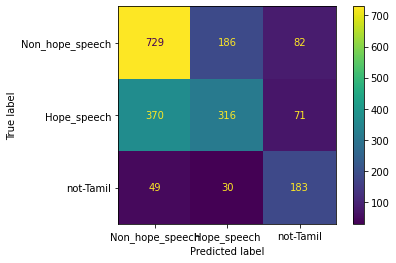

In [48]:
Ta_CNN_BiLSTM = create_model(Xtrain=tamil_train_pad_seq, ytrain=tamil_ytrain, Xtest=tamil_test_pad_seq, 
                             ytest=tamil_ytest, saved_model='Ta_CNN_BiLSTMModel.h5', fit=False, labels=tamil_labels)


----------Model Summary----------

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          1596100   
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 19, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 19, 64)           41216     
 onal)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1216)              0         
                                                                 
 dense_10 (Dense)

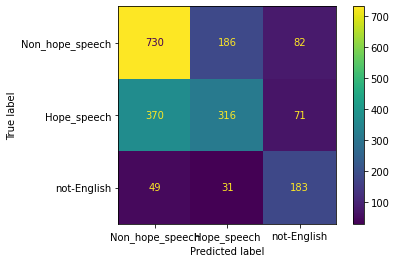

In [ ]:
Ta_CNN_BiLSTM = create_model(Xtrain=tamil_train_pad_seq, ytrain=tamil_ytrain, Xtest=tamil_test_pad_seq, 
                             ytest=tamil_ytest, model=Ta_CNN_BiLSTMModel, saved_model='Ta_CNN_BiLSTMModel.h5', fit=False, labels=tamil_labels)

In [ ]:
scores['tamil_scores']['Ta_CNN_BiLSTM'] = 0.5997

### Tamil with FastText  
---
Train Accuracy: 0.486  
Validation Accuracy: 0.491  
----------Test Scores----------  
Precision: 0.5731  
Recall: 0.5777  
F1-Score: 0.5674  
Accuracy: 0.5777  


----------Model Summary----------

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          9424500   
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 19, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 19, 64)           41216     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1216)              0         
                                                                 
 dense_3 (Dense)  

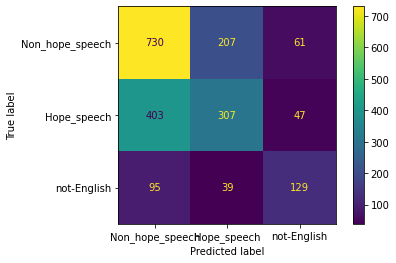

In [ ]:
Ta_FT_CNN_BiLSTM = create_model(Xtrain=tamil_train_pad_seq, ytrain=tamil_hope_train['enc_label'], Xtest=tamil_test_pad_seq, 
                                ytest=tamil_hope_test['enc_label'], model=Ta_FT_CNN_BiLSTMModel, saved_model='Ta_FT_CNN_BiLSTMModel.h5', 
                                fit=False)

In [ ]:
scores['tamil_scores']['Ta_FT_CNN_BiLSTM'] = 0.5674

## Elmo
**Links**  
https://towardsdatascience.com/transfer-learning-using-elmo-embedding-c4a7e415103c  
https://towardsdatascience.com/elmo-embeddings-in-keras-with-tensorflow-hub-7eb6f0145440  
https://www.youtube.com/watch?v=DXdJlY35eVE  
https://github.com/strongio/keras-elmo/issues/12  

### English with Elmo
Train Accuracy: 0.9231  
Validation Accuracy: 0.913   
----------Test Scores----------

Precision: 0.8966  
Recall: 0.9067  
F1-Score: 0.9007  
Accuracy: 0.9067  

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
embeddings = elmo(
    ["the cat is on the mat", "dogs are in the fog"],
    signature="default",
    as_dict=True)
embeddings

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


{'default': <tf.Tensor 'module_apply_default/truediv:0' shape=(2, 1024) dtype=float32>,
 'lstm_outputs1': <tf.Tensor 'module_apply_default/concat:0' shape=(2, 6, 1024) dtype=float32>,
 'sequence_len': <tf.Tensor 'module_apply_default/Sum:0' shape=(2,) dtype=int32>,
 'lstm_outputs2': <tf.Tensor 'module_apply_default/concat_1:0' shape=(2, ?, 1024) dtype=float32>,
 'elmo': <tf.Tensor 'module_apply_default/aggregation/mul_3:0' shape=(2, 6, 1024) dtype=float32>,
 'word_emb': <tf.Tensor 'module_apply_default/bilm/Reshape_1:0' shape=(2, 6, 512) dtype=float32>}

In [ ]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string), axis=1), signature="default", as_dict=True)["elmo"]

In [ ]:
En_ELMo_CNN_BiLSTMModel = tf.keras.models.Sequential([
            Input(shape=(1,), dtype="string"),
            Lambda(ELMoEmbedding, output_shape=(1024, )),
            Conv1D(256, 10, activation='relu'),
            MaxPooling1D(2, 3),
            Bidirectional(LSTM(units = 32,return_sequences=False,dropout = 0.3)),
            Dense(3 , activation='softmax')
          ])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
with tf.Session() as session:
    tf.keras.backend.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    En_ELMo_CNN_BiLSTM = create_model(Xtrain=english_Xtrain, ytrain=english_ytrain, Xtest=english_Xtest, ytest=english_ytest, val_split=0,
                                      model=En_ELMo_CNN_BiLSTMModel, saved_model="En_ELMo_CNN_BiLSTMModel.h5", fit=True)


----------Fitting Model----------

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 22762 samples
Epoch 1/30
22752/22762 [============================>.] - ETA: 0s - loss: 0.2641 - acc: 0.9130WARNING:tensorflow:Can save best model only with val_acc available, skipping.


22762/22762 [==============================] - 341s 15ms/sample - loss: 0.2640 - acc: 0.9130
Epoch 2/30
22752/22762 [============================>.] - ETA: 0s - loss: 0.2267 - acc: 0.9185WARNING:tensorflow:Can save best model only with val_acc available, skipping.


22762/22762 [==============================] - 303s 13ms/sample - loss: 0.2267 - acc: 0.9185
Epoch 3/30
22752/22762 [============================>.] - ETA: 0s - loss: 0.2097 - acc: 0.9233WARNING:tensorflow:Can save best model only with val_acc available, skipping.


22762/22762 [==============================] - 304s 13ms/sample - loss: 0.2096 - acc: 0.9234
Epoch 4/30
22752/22762 [============================>.] - ETA: 0s - loss: 0.1903 - acc: 0.9295WARNING:tensorflow:Can save best model only with val_acc available, skipping.


22762/22762 [==============================] - 303s 13ms/sample - loss: 0.1903 - acc: 0.9295
Epoch 5/30
22752/22762 [============================>.] - ETA: 0s - loss: 0.1722 - acc: 0.9352WARNING:tensorflow:Can save best model only with val_acc available, skipping.


22762/22762 [==============================] - 302s 13ms/sample - loss: 0.1722 - acc: 0.9352
Epoch 6/30
10912/22762 [=============>................] - ETA: 2:40 - loss: 0.1405 - acc: 0.9479

In [ ]:
En_ELMo_CNN_BiLSTM

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f6d1a6a0ed0>,
 array([0, 0, 0, 0, 0]),
 {'F1-Score': 0.7111111111111111,
  'Accuracy': 0.8,
  'Precision': 0.64,
  'Recall': 0.8,
  'Classification Report': '                 precision    recall  f1-score   support\n\nNon_hope_speech       0.80      1.00      0.89         4\n    Hope_speech       0.00      0.00      0.00         1\n    not-English       0.00      0.00      0.00         0\n\n      micro avg       0.80      0.80      0.80         5\n      macro avg       0.27      0.33      0.30         5\n   weighted avg       0.64      0.80      0.71         5\n',
  'Confusion Matrix Display': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f6d1a702e10>})

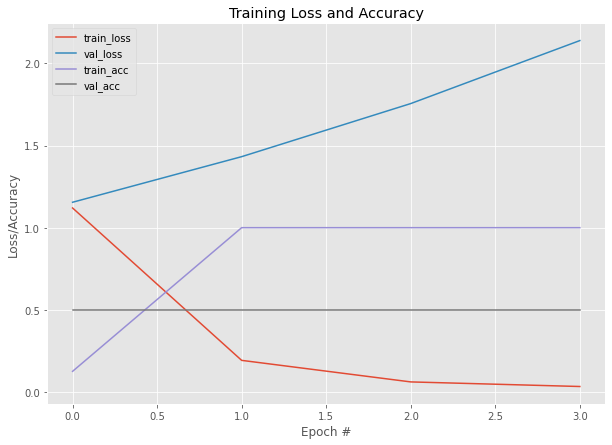

In [ ]:
plot_history(En_ELMo_CNN_BiLSTM[2], '/content/plots/En_ELMo_CNN_BiLSTMHistory.png')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



----------Fitting Model----------

Train on 15933 samples, validate on 6829 samples
Epoch 1/5
15904/15933 [============================>.] - ETA: 0s - loss: 0.1839 - acc: 0.9319
Epoch 00001: val_acc improved from -inf to 0.91419, saving model to En_ELMo_CNN_BiLSTMModel.h5
15933/15933 [==============================] - 330s 21ms/sample - loss: 0.1841 - acc: 0.9318 - val_loss: 0.2353 - val_acc: 0.9142
Epoch 2/5
15904/15933 [============================>.] - ETA: 0s - loss: 0.1482 - acc: 0.9453
Epoch 00002: val_acc improved from 0.91419 to 0.91712, saving model to En_ELMo_CNN_BiLSTMModel.h5
15933/15933 [==============================] - 294s 18ms/sample - loss: 0.1481 - acc: 0.9453 - val_loss: 0.2465 - val_acc: 0.9171
Epoch 3/5
15904/15933 [============================>.] - ETA: 0s - loss: 0.1113 - acc: 0.9589
Epoch 00003: val_acc did not improve from 0.91712
15933/15933 [==============================] - 292s 18ms/sample - loss: 0.1112 - acc: 0.9590 - val_loss: 0.2817 - val_acc: 0.9077


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



----------Model Summary----------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1024)        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         655488    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 696,899
Trainable params: 696,899
Non-trainable params: 0
_________________________________________________________________
None

----------Test Scores----------

Precision: 0.8923180401809435
Recall: 0.9

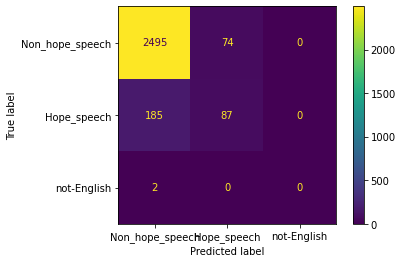

In [ ]:
with tf.Session() as session:
    tf.keras.backend.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    En_ELMo_CNN_BiLSTM = create_model(Xtrain=english_Xtrain, ytrain=english_ytrain, Xtest=english_Xtest, ytest=english_ytest,
                                      lr=0.001, batch_size=32, epochs=5, val_split=0.3, saved_model="En_ELMo_CNN_BiLSTMModel.h5", fit=True)

### Tamil with Elmo
Train Accuracy: 0.6247  
Validation Accuracy: 0.5856   
----------Test Scores----------

Precision: 0.5758  
Recall: 0.5823  
F1-Score: 0.5725  
Accuracy: 0.5823  

In [ ]:
tamil_elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

In [ ]:
def Ta_ELMoEmbedding(x):
    return tamil_elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [ ]:
Ta_ELMo_CNN_BiLSTMModel = tf.keras.models.Sequential([
            Input(shape=(1,), dtype="string"),
            Lambda(Ta_ELMoEmbedding, output_shape=(1024, )),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(5),
            Bidirectional(LSTM(units = 32,return_sequences=False,dropout = 0.2)),
            Dense(3 , activation='softmax')
          ])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
with tf.Session() as session:
    tf.keras.backend.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    Ta_ELMo_CNN_BiLSTM = create_model(Xtrain=tamil_Xtrain, ytrain=tamil_ytrain, Xtest=tamil_Xtest, ytest=tamil_ytest,
                                      lr=0.001, batch_size=32, epochs=5, val_split=0.3, model=Ta_ELMo_CNN_BiLSTMModel,
                                      saved_model="Ta_ELMo_CNN_BiLSTMModel.h5", fit=True, plot=False)


----------Fitting Model----------

Train on 11312 samples, validate on 4848 samples
Epoch 1/5
11296/11312 [============================>.] - ETA: 3s - loss: 0.8257 - acc: 0.5398 
Epoch 00001: val_acc improved from -inf to 0.56724, saving model to Ta_ELMo_CNN_BiLSTMModel.h5
11312/11312 [==============================] - 3996s 353ms/sample - loss: 0.8256 - acc: 0.5398 - val_loss: 0.7945 - val_acc: 0.5672
Epoch 2/5
11296/11312 [============================>.] - ETA: 4s - loss: 0.7791 - acc: 0.5786 
Epoch 00002: val_acc improved from 0.56724 to 0.57302, saving model to Ta_ELMo_CNN_BiLSTMModel.h5
11312/11312 [==============================] - 4125s 365ms/sample - loss: 0.7791 - acc: 0.5787 - val_loss: 0.7809 - val_acc: 0.5730
Epoch 3/5
11296/11312 [============================>.] - ETA: 4s - loss: 0.7474 - acc: 0.6052 
Epoch 00003: val_acc improved from 0.57302 to 0.57673, saving model to Ta_ELMo_CNN_BiLSTMModel.h5
11312/11312 [==============================] - 4208s 372ms/sample - loss: 0

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



----------Model Summary----------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         655488    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 696,899
Trainable params: 696,899
Non-trainable params: 0
_________________________________________________________________
None

----------Test Scores----------

Precision: 0.5758934463988165
Recall: 0

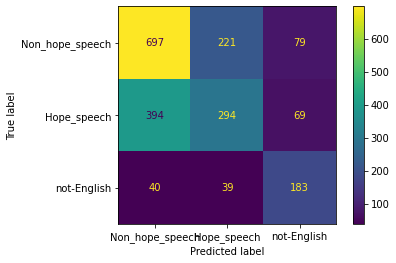

In [ ]:
with tf.Session() as session:
    tf.keras.backend.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    Ta_ELMo_CNN_BiLSTM = create_model(Xtrain=tamil_Xtrain, ytrain=tamil_ytrain, Xtest=tamil_Xtest, ytest=tamil_ytest,
                                      lr=0.001, batch_size=32, epochs=2, val_split=0.3, saved_model="Ta_ELMo_CNN_BiLSTMModel-3.h5", fit=False)

## Plots

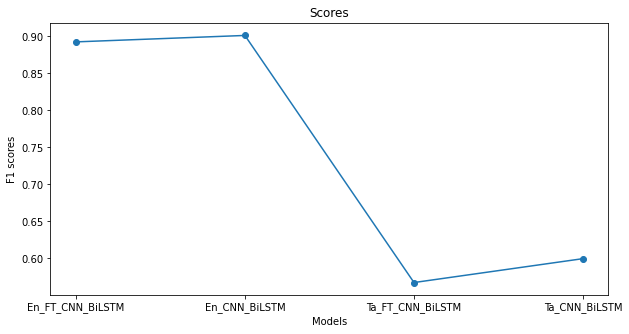

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(scores['english_scores'].keys())+list(scores['tamil_scores'].keys()), list(scores['english_scores'].values())+list(scores['tamil_scores'].values()), 'o-')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Scores')
plt.show()